# Introduction

Public-facing CEOs such as Elon Musk directly communicate with people through social networking services like Twitter. Could there be a relationship between the positive sentiment of his tweets and the price fluctuations in the stock price of TSLA? Surely such a relationship could be exploited for financial gain. 

This report will detail data gathering, data processing, feature selection, as well as model fitting, and model testing.

---

# Methods

## Population of Interest

Our population of interest are all tweets by Tesla founder Elon Musk from the beginning of the stock market crash of 2020 to the end of the market crash of 2020.

In [14]:
from searchtweets import gen_rule_payload, ResultStream
from os import environ

API_CONFIG = dict(
    endpoint="https://api.twitter.com/1.1/tweets/search/fullarchive/experiment.json",
    bearer_token=environ["TWITTER_BEARER_TOKEN"]
)

def tweet_stream():
    rule = gen_rule_payload(
        pt_rule="(tesla OR TSLA) from:elonmusk",
        from_date="2020-02-20",
        to_date="2020-10-26",
        results_per_call=100
    )
    rs = ResultStream(
        rule_payload=rule,
        max_results=4000,
        tweetify=False,
        **API_CONFIG
    )
    return rs.stream()


### Sample Tweets

In [15]:
import pandas as pd

columns = {"created_at", "text", "quote_count", "reply_count", "retweet_count", "favorite_count"}

df = pd.DataFrame(
    {k: v for (k, v) in tweet.items() if k in columns} for tweet in tweet_stream()
)
df = df.set_index(pd.to_datetime(df["created_at"], utc=True).dt.date).drop(["created_at"], axis=1)
df.head()

,text,quote_count,reply_count,retweet_count,favorite_count
created_at,,,,,
2020-10-25,"@arctechinc @Tesla Yes, very helpful. Thanks a...",29,196,106,3267
2020-10-22,Now that Tesla FSD beta is out in limited rele...,777,3326,2576,59995
2020-10-22,@TeslaGong @PPathole @teslaownersSV @tesla_raj...,29,156,150,2215
2020-10-22,@PPathole @teslaownersSV @tesla_raj Yes,6,51,34,809
2020-10-22,@teslaownersSV @tesla_raj Haha,35,295,222,10206


We seek to use the sentiment of these tweets to predict the change in stock price, so we load OHLC data for the TSLA stock from Yahoo Finance.

### Tesla Stock Data

In [17]:
import numpy as np
import pandas as pd

from yahoofinancials import YahooFinancials

historical_data = YahooFinancials("TSLA").get_historical_price_data("2020-02-01", "2020-11-24", "daily")["TSLA"]
df = pd.DataFrame(historical_data["prices"])
df.set_index("date", inplace=True)
df.head()

,high,low,open,close,volume,adjclose,formatted_date
date,,,,,,,
1580740200,157.227997,134.703995,134.738007,156.000000,236167500,156.000000,2020-02-03
1580826600,193.798004,166.776001,176.591995,177.412003,304694000,177.412003,2020-02-04
1580913000,169.195999,140.822006,164.651993,146.940002,242119000,146.940002,2020-02-05
1580999400,159.166000,137.399994,139.983994,149.792007,199404000,149.792007,2020-02-06
1581085800,153.949997,146.000000,146.110001,149.613998,85317500,149.613998,2020-02-07


### Target Variable Processing

To use the sentiment analysis as a signal we seek to predict the percentage change or the log of the percent change. We generate target variables for lookback periods of 2, 3, 7, or 14 days.

In [18]:
for n in {2, 3, 7, 14}:
    df[f"pct_change_{n}_days"] = df["close"].pct_change(periods=n)
    df[f"log_return_{n}_days"] = (np.log(df["close"]) - np.log(df["close"].shift(n)))

df.drop(["high", "low", "open", "close", "adjclose"], axis=1, inplace=True)
df.to_csv("data/stock.csv")
df.tail()

,volume,formatted_date,pct_change_2_days,log_return_2_days,pct_change_3_days,log_return_3_days,pct_change_14_days,log_return_14_days,pct_change_7_days,log_return_7_days
date,,,,,,,,,,
1605623400,61188300,2020-11-17,0.081053,0.077935,0.072494,0.069986,0.087656,0.084025,0.027119,0.026758
1605709800,78044000,2020-11-18,0.192482,0.176037,0.191285,0.175033,0.184529,0.169345,0.155201,0.144274
1605796200,62475300,2020-11-19,0.130568,0.122720,0.223431,0.201659,0.286646,0.252039,0.216663,0.196112
1605882600,32807300,2020-11-20,0.006103,0.006084,0.108693,0.103182,0.222466,0.200870,0.173759,0.160211
1606141800,50260300,2020-11-23,0.045226,0.044233,0.072353,0.069855,0.231069,0.207883,0.267364,0.236939


### Input Variable Processing

We pass the text of the tweet directly to Amazon Comprehend for sentiment analysis, and keep note of the positive sentiment score assigned to the tweet. Comprehend's sentiment analysis is a language model scores text on a scale of 0 to 1 inclusive on the "positivity" scale.

In [16]:
import boto3

comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')

def detect_positive_sentiment(text: str):
    response = comprehend.detect_sentiment(Text=text, LanguageCode="en")
    return response["SentimentScore"]["Positive"]

df["positive_sentiment"] = df.apply(lambda tweet: detect_positive_sentiment(tweet.text), axis=1)
df.tail()

,text,quote_count,reply_count,retweet_count,favorite_count,positive_sentiment
created_at,,,,,,
2020-02-26,@Erdayastronaut @JaneidyEve @JakeTheHuman28 @t...,11,121,103,3620,0.001926
2020-02-26,@JaneidyEve @JakeTheHuman28 @tesla_truth @Twit...,32,101,230,3141,0.011249
2020-02-22,Getting there was super hard. Very proud of Te...,46,557,530,20480,0.966579
2020-02-22,Model 3 achieves 350 mile actual range vs 310 ...,212,1153,2234,30901,0.020993
2020-02-20,RT @Tesmanian_com: Tesla Model 3 Is Consumer R...,0,0,0,0,0.055207


In [265]:
df.to_csv("data/tweets.csv")

In [2]:
"""
Okay, so none of our distributions are normalized.
Let's do some preprocessing, saving what we have so far.
"""

import pandas as pd

tweets = pd.read_csv("data/tweets.csv", index_col=0, parse_dates=True)
tweets.drop(["text"], axis=1, inplace=True)

stock = pd.read_csv("data/stock.csv", index_col=0, parse_dates=True)
stock.index = pd.to_datetime(stock.index, unit="s").date

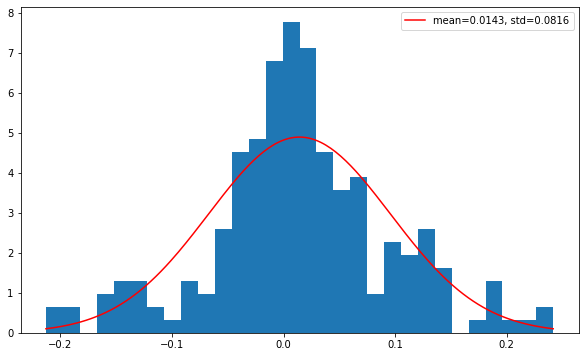

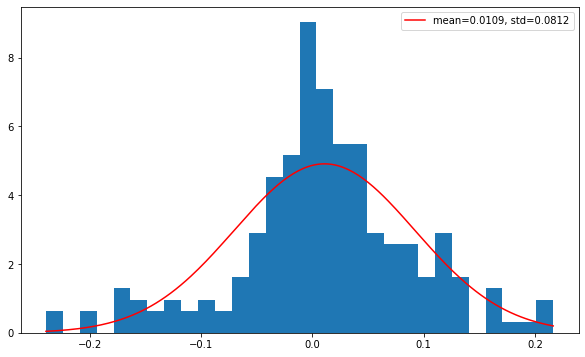

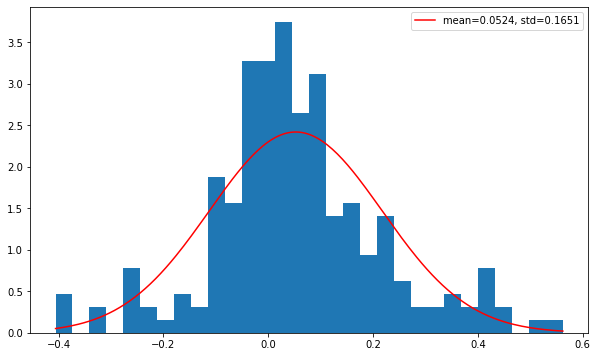

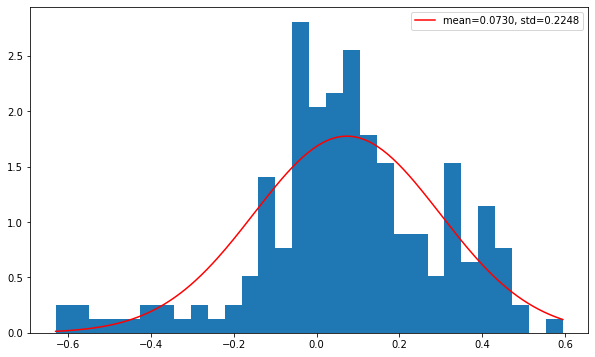

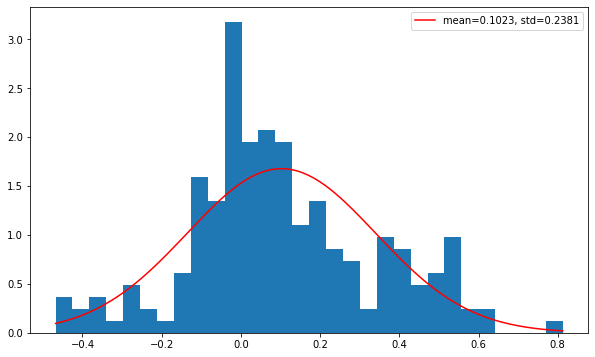

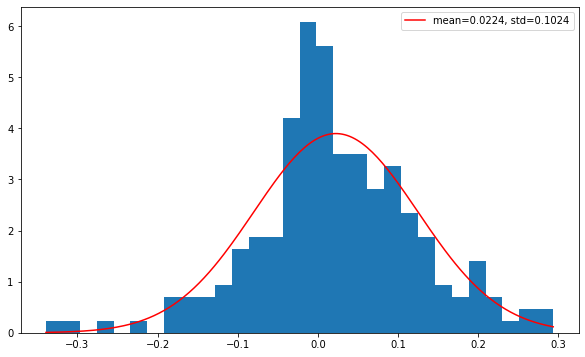

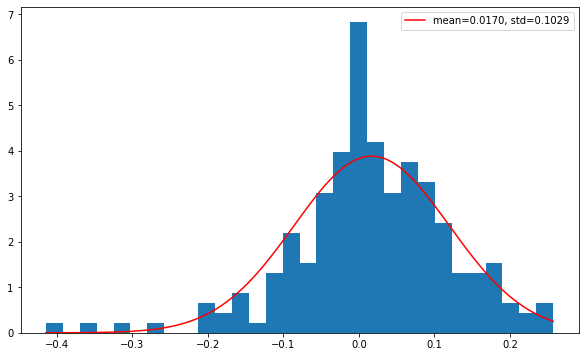

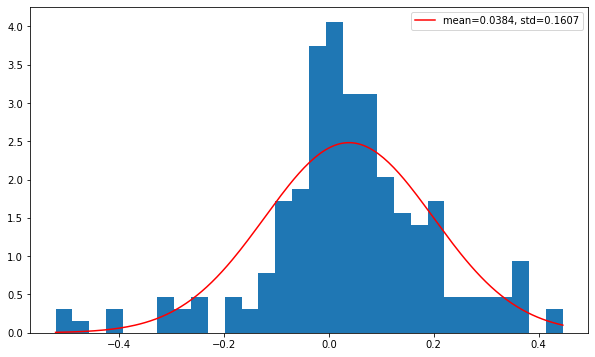

In [3]:
"""
Visualizing our target variables.

We need normally-distributed data with zero mean and unit variance.

After running this cell, by the looks of it, there is a slight positive skew.

I wonder how we can normalize this.

Now I'm reading: https://scikit-learn.org/stable/modules/preprocessing.html
"""

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def plot_distribution(pd_series):
    x = np.linspace(pd_series.min(), pd_series.max(), len(pd_series))
    loc, scale = stats.norm.fit(pd_series)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(pd_series, bins=30, density=True)
    ax.plot(x, stats.norm.pdf(x, loc=loc, scale=scale), "r-", label="mean=%.4f, std=%.4f" % (loc, scale))
    ax.legend(loc="best")

train_columns = {"quote_count", "reply_count", "retweet_count", "favorite_count", "positive_sentiment"}
target_columns = {c for c in df.columns if c.startswith("pct_change") or c.startswith("log_return")}

for c in target_columns:
    plot_distribution(stock[c].dropna())


## Model Training

Because of the multitude of input variables and the multitude of target variables, we want to run a grid search of the possible models. To help, we define a `train` function that we then use to train estimators across the cartesian product of the 4 different look back periods as well as the different target variable types (percent change or log of percent change).

We use the standard k-fold shuffle split with k=5 as supplied by the `sklearn.model_selection.cross_validate` function.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def train(target, shift):
    stock_df = (
        stock
        .copy()
        .set_index(stock.index - pd.DateOffset(days=shift))
    )
    data = tweets.join(stock_df, how="inner", sort=True).dropna(axis=1)
    X = data[["positive_sentiment"]]
    y = data[f"{target}_{shift}_days"]
    model = LinearRegression(normalize=True)
    return cross_validate(model, X, y, return_estimator=True)


## Results

In [11]:
from pprint import pprint

results = []

for n in {2, 3, 7, 14}:
    log_result = train("log_return", n)
    for (estimator, test_score) in zip(log_result["estimator"], log_result["test_score"]):
        results.append(["log_return", n, estimator.coef_[0], estimator.intercept_, test_score])
    pct_result = train("pct_change", n)
    for (estimator, test_score) in zip(pct_result["estimator"], pct_result["test_score"]):
        results.append(["pct_change", n, estimator.coef_[0], estimator.intercept_, test_score])

result_df = pd.DataFrame(results, columns=["target_variable", "history", "coefficient", "intercept", "score"]).sort_values(["target_variable", "history"])
result_df.head()

,target_variable,history,coefficient,intercept,score
0,log_return,2,0.042839,0.017765,-0.112836
1,log_return,2,0.029714,0.008760,-0.017781
2,log_return,2,0.025339,0.010943,0.015502
3,log_return,2,0.033336,0.001784,-0.449251
4,log_return,2,0.031982,0.016994,-0.187150


As per the [Sci-Kit Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score), the score is:

> The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

### Conclusion

Sorting our results by score below, and noting the definition of the score above, we can see that most of our models were actually worse than a coin flip, and the better models were negligibly better than models that would disregard any of our input features.

In [13]:
result_df.sort_values("score")

,target_variable,history,coefficient,intercept,score
29,pct_change,14,0.104827,0.139354,-6.285845
24,log_return,14,0.091562,0.101580,-3.897274
22,log_return,14,0.061534,0.034479,-2.413867
27,pct_change,14,0.065158,0.061236,-1.772447
36,pct_change,7,0.103581,0.047697,-0.661396
26,pct_change,14,0.093033,0.114685,-0.574579
16,pct_change,3,0.021571,0.053243,-0.526097
31,log_return,7,0.095438,0.032105,-0.495819
32,log_return,7,0.066839,0.018315,-0.458784
3,log_return,2,0.033336,0.001784,-0.449251
